# Elevation Map Rough Draft

This is a rough draft of the elevation map.  Just proving the concepts really making sure everything is on the correct path

In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import geoplot as gplt
import geopandas as gpd
import pylas
import gc
from shapely.geometry import Point
import pandas as pd
import utm
import zipfile
from matplotlib.colors import LogNorm, TwoSlopeNorm, Normalize, SymLogNorm
import matplotlib.ticker as ticker

epsg = 4289
lasPath = './USGS_LPC_LA_UpperDeltaPlain_2017_LAS_2018/las/tiled/'
extent = (-90.14003111,  29.86560481, -89.87, 30.08)

In [2]:
def nameReplace(name):
    outName = name.title().replace(' ',"\n").split('-')[0]
    outName = outName.replace("St.\n",'St.') #Fix Saint abrevation problem
    return outName

neighborhoodDf = gpd.read_file('zip://./NewOrleansShapeFiles/Neighborhood_Statistical_Areas.zip!Neighborhood_Statistical_Areas.shp').to_crs(epsg=epsg)
neighborhoodDf['Name'] = neighborhoodDf['GNOCDC_LAB'].map(nameReplace)
waterDf = gpd.read_file('zip://./NewOrleansShapeFiles/water.zip!WATER2.SHP')
roadsDf = gpd.read_file('zip://./NewOrleansShapeFiles/Road_Centerline.zip!Road_Centerline.shp')
roadsDf = roadsDf[roadsDf['geometry'].apply(lambda x: x != None)]
interstateDf = roadsDf[np.logical_or(roadsDf['FEDROUTE'] =='10', roadsDf['FEDROUTE'] =='610')].to_crs(epsg=epsg)

In [3]:
lasDf = gpd.GeoDataFrame(pd.read_pickle('./processedData.pickle'))
lasDf = lasDf[lasDf['intersectsCity']]
groundMask = lasDf['pointType']==2
waterMask = lasDf['pointType']==9
lasDf['elevationFeet'] = 3.28084 * lasDf['elevation']
norm = Normalize(vmin=-10, vmax=10, clip=True)
lasDf['elevationNorm'] = norm(lasDf['elevationFeet'], clip=True)

In [4]:
lasDf['aboveSea'] = 1 * (lasDf['elevation'] > 0)

In [5]:
extent = (-90.14003111,  29.86560481, -89.87, 30.08)

@ticker.FuncFormatter
def formatter(x, pos):
    outLabel = int(norm.inverse(x))
    
    if outLabel == 10:
        outLabel = '>= 10 feet'
    elif outLabel == -10:
        outLabel = '<= -10 feet'
    else:
        outLabel = str(outLabel) + ' feet'
        
    return outLabel


def graphMap(saveFig = False,
             showLidar = True,
             extent=extent,
             annotate=True,
             webMerc= False,
             cmap='gnuplot',
             figSize=(28,16),
             showInterstates=False):
    
    projection = gplt.Mercator() if not webMerc else gplt.WebMercator()
    epsgCode = 3395 if not webMerc else 3857

    title='Feet Above Sea Level'
    
    fig, ax = plt.subplots(figsize=figSize, subplot_kw={'projection': projection})

    if webMerc:
        gplt.webmap(neighborhoodDf, projection=projection,ax=ax, extent=extent)
        
    else:
        gplt.polyplot(neighborhoodDf, edgecolor='black', facecolor='#ffffff', projection=projection, ax=ax, extent=extent, zorder=19)    
        
        
    gplt.polyplot(waterDf,ax=ax, projection=projection, edgecolor='#abd3df', facecolor='#abd3df', extent=extent, zorder=22)
    gplt.polyplot(neighborhoodDf, edgecolor='black', facecolor=(1,0,0,0), projection=projection, ax=ax, extent=extent, zorder=24)
    
    if showInterstates:
        gplt.sankey(interstateDf,ax=ax, projection=projection, extent=extent, linewidth=5, zorder=25, color=(0,0,0,0.4))
    
    #currently this doesnt work
    if annotate:
        centers = neighborhoodDf.to_crs(epsgCode).centroid
        for point, name in zip(centers, neighborhoodDf['Name']):
            ax.annotate(name, xy=(point.x,point.y), xycoords='data', zorder=100,\
                        ha='center', va='center',fontsize=8, color='#000000',\
                        xytext=(-20, -20), textcoords="offset points",\
                        bbox=dict(boxstyle='round',facecolor='#ffffce', alpha=0.4))
            

    if showLidar:
        gplt.choropleth(lasDf[groundMask],hue='elevationNorm', legend=True, ax=ax, projection=projection, zorder=20, extent=extent, cmap=cmap)
        cbar = fig.get_axes()[-1]
        cbar.yaxis.set_major_formatter(formatter)            

    ax.set_facecolor('#ffffce')
    ax.set_title(title)
    fig.tight_layout()
    
    

    if saveFig:
        fig.savefig(saveFig)

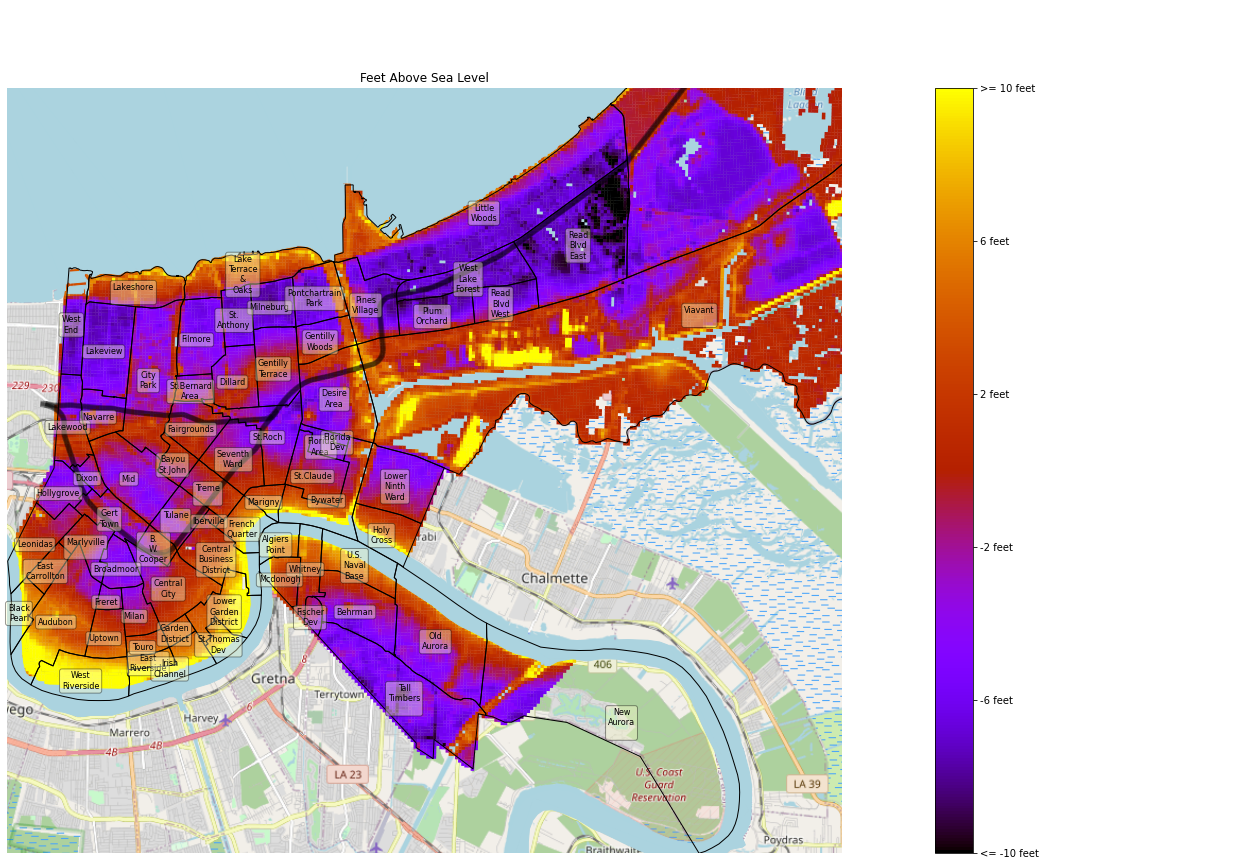

In [6]:
graphMap(showLidar=True,
         showInterstates=True,
         webMerc=True,
         saveFig='./NewOrleansElevation1.png')